# Efficiently Solving Stiff Differential Equations


## Imports

In [1]:
# Mathematical tools
using LinearAlgebra
using DifferentialEquations
using Symbolics
using ForwardDiff
using SparseDiffTools

# Graphs
using Graphs
using NetworkLayout

# General tools
using BenchmarkTools

# Plotting
using Colors, ColorSchemes
using Plots

# Plotting graphs
using CairoMakie
using GraphMakie

## Example stiff ODE system | Brusselator

In [2]:
function brusselator!(dwdt, w, N, t)
    """
    This function returns the right hand side of 
    the ODE system of the Brusselator problem as given
    in "Solving Ordinary Differential Equations II" by 
    Hairer and Wanner.
    """
    # Extract u and v from w, a 1D array of length 2(N + 2)
    u = w[1:N+2]; v = w[N+3:end]

    # Brusselator parameter
    alpha = 1/50

    # Cell size
    h = 1/(N+1)

    # Right hand side of the ODE system, constant boundary conditions
    offset = N + 2

    # dudt[1] = 0; dudt[end] = 0; dvdt[1] = 0; dvdt[end] = 0 not needed
    dwdt[2:N+1] .= 1 .+ u[2:N+1].^2 .* v[2:N+1] .- 4 .* u[2:N+1] .+ alpha ./ h^2 .* (u[1:N] .- 2 .* u[2:N+1] .+ u[3:N+2])
    dwdt[2 + offset:N+1 + offset] .= 3 .* u[2:N+1] .- u[2:N+1].^2 .* v[2:N+1] .+ alpha ./ h^2 .* (v[1:N] .- 2 .* v[2:N+1] .+ v[3:N+2])
end

brusselator! (generic function with 1 method)

### Initialization of the Brusselator

In [3]:
# Init brusselator
function init_brusselator(N)
    """
    This function returns the initial values for the 
    Brusselator problem.
    """
    x = range(0, 1, length=N+2)

    u0 = 1 .+ sin.(2 .* pi .* x)
    v0 = zeros(N+2) .+ 3
    u0[1] = 1; u0[end] = 1; v0[1] = 3

    w = vcat(u0, v0)

    return x, w
end

init_brusselator (generic function with 1 method)

### Helpers for the Brusselator system

In [4]:
function sol_to_u_v(sol, N)
    """
    This function returns the solution of the Brusselator
    problem as a tuple of u and v.
    """
    # sol is sadly Vector{Vector{Float64}}
    u = [sol.u[i][j] for i = 1:length(sol.u), j = 1:N+2]
    v = [sol.u[i][j] for i = 1:length(sol.u), j = N+3:length(sol.u[1])]
    return u, v
end

sol_to_u_v (generic function with 1 method)

In [5]:
function wbrusselator!(dwdt, w)
    """
    Wrapped brusselator function that takes a vector w as input.
    N = (length(w) - 2) / 2
    """
    N = Int32(length(w) / 2 - 2)
    print(N)
    brusselator!(dwdt, w, N, 0)
end

wbrusselator! (generic function with 1 method)

## Sparse matrix and graph functionality

In [6]:
function sparsity_matrix_to_graph(sp_mat)
    """
    Each column of the sparsity matrix is a node in the graph.
    Two nodes are connected if the corresponding columns overlap, i. e.
    if there is a non-zero entry in the same row of both columns.
    """
    # Get number of columns
    n = size(sp_mat, 2)

    # Create empty graph
    g = SimpleGraph(n)

    # Iterate over columns
    for i in 1:n
        # Get indices of non-zero entries in column i
        nz = findall(!iszero, sp_mat[:, i])

        for j in i + 1:n
            # Get indices of non-zero entries in column j
            nz2 = findall(!iszero, sp_mat[:, j])

            # Check if there is a non-zero entry in the same row
            if length(intersect(nz, nz2)) > 0
                # Add edge between column i and j
                add_edge!(g, i, j)
            end
        end
    end

    return g
end


function condense_sparsity_pattern(mat, coloring)
    """
    This function condenses the sparsity pattern of a matrix.
    """
    # number of colors
    n_colors = coloring.num_colors
    # condenset sparsity pattern
    cm = zeros(size(mat, 1), n_colors)
    for i in 1:n_colors
        cm[:, i] = sum(mat[:, coloring.colors .== i], dims=2)
    end
    return cm
end

condense_sparsity_pattern (generic function with 1 method)

## Plot functionality

### Plotting the solution of the ODE system

In [20]:
function plot_as_2D_surface(u, t, x)
    """
    This function plots the solution of the Brusselator
    problem as a 2D surface.
    """
    Plots.surface(x, t, u, xlabel="x", ylabel="t", zlabel="u", color=:coolwarm, title="Brusselator")
end

function anim_plot_1D(u, N)
    """
    This function animates the solution of the Brusselator
    problem as a 1D line plot.
    """
    x = range(0, stop=1, length=N+2)

    anim = @animate for i in 1:100
        Plots.plot(x, u[i, :], xlims=(0, 1), ylims=(0, 4), xlabel="x", ylabel="u", title="Brusselator", legend=false, grid=true)
    end

    gif(anim, "figures/bruss_ani.gif", fps=10)

end

plot_colored_sparsity_pattern (generic function with 1 method)

### Plotting sparse matrices

In [203]:
function scatter_matrix_plot(mat, cm, title)
    x = [i for i in 1:size(mat, 2) for j in 1:size(mat, 1)]
    y = [j for i in 1:size(mat, 2) for j in 1:size(mat, 1)]

    c = [cm[i, j] for j in 1:size(mat, 2) for i in 1:size(mat, 1)]
    
    CairoMakie.scatter(x, y, color = c, marker = :rect, markersize = 50, axis = (aspect = DataAspect(), xgridvisible = false, ygridvisible = false, xticks = 1:size(mat, 2), yticks = 1:size(mat, 1), xlabel = "column-index", ylabel = "row-index", title = title))
    # invert y axis
    CairoMakie.ylims!(size(mat, 1) + 0.8, 0)
    CairoMakie.xlims!(0, size(mat, 2) + 1)
    # show plot
    display(CairoMakie.current_figure())
end

function plot_sparsity_pattern(mat, title = "Sparsity pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = zeros(size(mat, 1), size(mat, 2))
    cm[mat .== 0] .= 0.9
    cm[mat .== 1] .= 0
    cm = RGB.(cm)
    scatter_matrix_plot(mat, cm, title);
end

# function plot_colored_sparsity_pattern(mat, colors)
#     """
#     This function plots the sparsity pattern of a matrix.
#     """
#     cm = RGB.(mat)
#     cm[mat .== 0] .= 0.9

#     # loop through columns and assign color to all non-zero entries
#     for i in 1:size(mat, 2)
#         cm[mat[:, i] .!= 0, i] .= colors[i]
#     end
#     RGB.(cm)
# end

function plot_sparsity_pattern(mat, colors, title = "Sparsity Pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = RGB.(mat)
    cm[mat .== 0] .= 0.9

    # loop through columns and assign color to all non-zero entries
    for i in 1:size(mat, 2)
        cm[mat[:, i] .!= 0, i] .= colors[i]
    end

    cm = RGB.(cm)
    RGB.(cm)

    scatter_matrix_plot(mat, cm, title);
    
end


plot_sparsity_pattern (generic function with 3 methods)

### Graph plotting

In [249]:
# Use CairoMakie with SVG output
CairoMakie.activate!(type = "svg")

function plot_graph(g, coloring)
    """
    This function plots the graph of the sparsity pattern, colored according to the coloring.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = node_colors(coloring, g), nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    
    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph.svg", f)
end

function plot_graph(g)
    """
    This function plots the graph of the sparsity pattern.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = :black, nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, nlabels_color = :white, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    # add a title, title!("Graph of the sparsity pattern") does not work

    # text!(ax, "Graph representation of \n Jacobian sparsity matrix", position=(-1.6, 1), fontsize = 30)

    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph.svg", f)
end

# Fix for GraphMakie labels being displayed outside of the plot
# taken from https://discourse.julialang.org/t/textbox-graph-with-networklayout-with-labels-cut-off-using-graphmakie/96566/4
# by @hexaeder
function update_limits!(ax)
    p = only(ax.scene.plots)
    @assert p isa GraphPlot
    nodep = get_node_plot(p)
    textp = get_nlabel_plot(p)

    to_corners = r -> (Point2f(r.origin[1:2]), Point2f(r.origin[1:2] + r.widths[1:2]))
    to_px = pts -> Makie.project(ax.scene, pts)

    # get lower left and upper right node bounding box in data and px space
    n1_dat, n2_dat = to_corners(boundingbox(nodep))
    n1, n2         = to_px(n1_dat), to_px(n2_dat)

    # get text bounding box in pixel sapce
    t1, t2 = to_corners(boundingbox(textp))

    # get axis limits in data and pixel space
    ax1_dat, ax2_dat = to_corners(ax.finallimits[])
    ax1, ax2         = to_px(ax1_dat), to_px(ax2_dat)

    # check difference between nodelabel and node bounding box in px
    px_diff1 = map(x->min(0, x), t1-n1)
    px_diff2 = map(x->max(0, x), t2-n2)

    # define "targets" in pixelspace where n1 and n2 bounding should end up
    n1_target = ax1-px_diff1 + Point2f(20, 20)
    n2_target = ax2-px_diff2 - Point2f(20, 20)

    # calculate axis limits such as bounding box of node plot goes to target
    scale = (n2_dat - n1_dat) ./ (n2_target - n1_target)
    origin = n1_dat - scale .* (n1_target - ax1)
    width = ((n2_dat - n1_dat) ./ (n2_target - n1_target)) .* (ax2 - ax1)

    CairoMakie.xlims!(ax, origin[1], origin[1]+width[1] )
    CairoMakie.ylims!(ax, origin[2], origin[2]+width[2] )
end

update_limits! (generic function with 1 method)

## Further helpers

In [10]:
# Plot g with coloring and column indices as labels
function node_colors(coloring, g)
    return [ColorSchemes.tol_light.colors[coloring.colors[i]] for i in 1:nv(g)]
end

function unique_colors(coloring)
    return [ColorSchemes.tol_light.colors[i] for i in 1:coloring.num_colors]
end

unique_colors (generic function with 1 method)

## Solution playground

In [11]:
# Brusselator parameters
N = 5 # number of grid points
t_0 = 0.0 # initial time
t_end = 10.0 # end time
t = range(t_0, t_end, length=100) # saved time steps
x, w = init_brusselator(N) # initial conditions

# Define the ODE problem
ode_prob = ODEProblem(brusselator!, w, (0, 10), N)

# Solve the ODE problem
sol = solve(ode_prob, TRBDF2(), saveat=t);

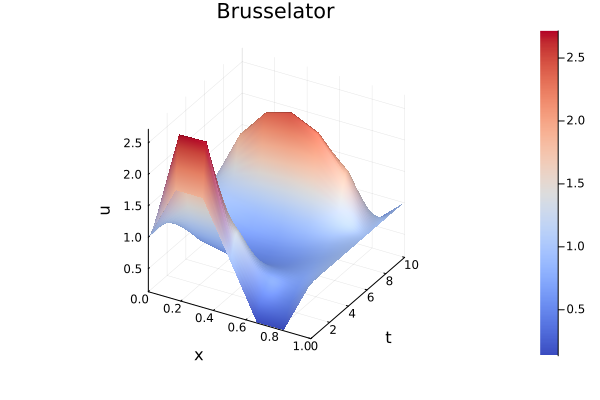

In [12]:
# Plot the solution as a surface over space and time
u, v = sol_to_u_v(sol, N)
plot_as_2D_surface(u, t, x)

┌ Info: Saved animation to c:\Users\leona\OneDrive\Dokumente\Studium\Master\2. Semester\Scientific Machine Learning\Code\figures\bruss_ani.gif
└ @ Plots C:\Users\leona\.julia\packages\Plots\p3KMq\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\leona\\OneDrive\\Dokumente\\Studium\\Master\\2. Semester\\Scientific Machine Learning\\Code\\figures\\bruss_ani.gif")
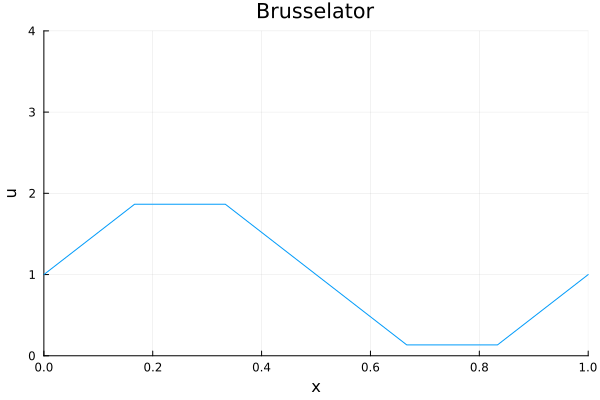

In [13]:
# Animate the the change of the solution over time
anim_plot_1D(u, N)

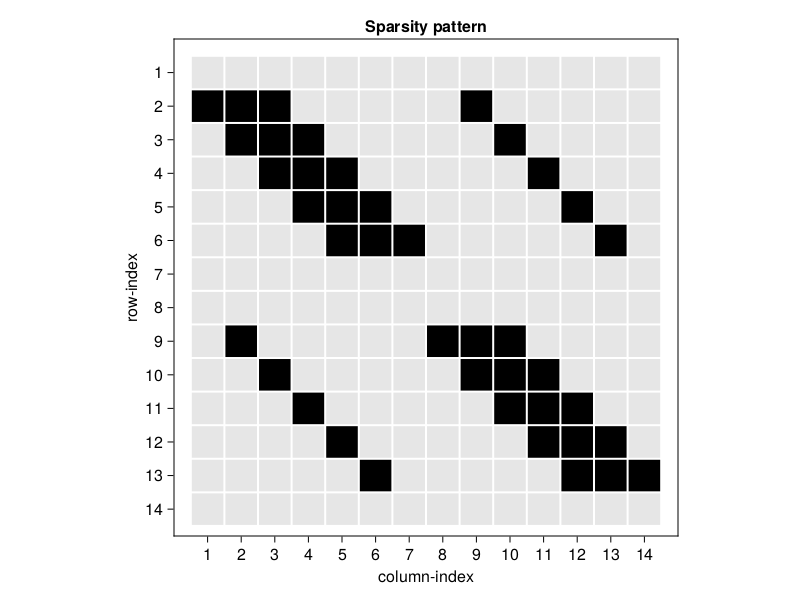

CairoMakie.Screen{IMAGE}


In [202]:
# Find the sparsity pattern of the Jacobian of the ODE considered
dwdt0 = zeros(2(N + 2)) # initialization of the derivative
sparsity = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0, w) # find the sparsity pattern

# Plot the sparsity pattern of the Jacobian
plot_sparsity_pattern(sparsity)

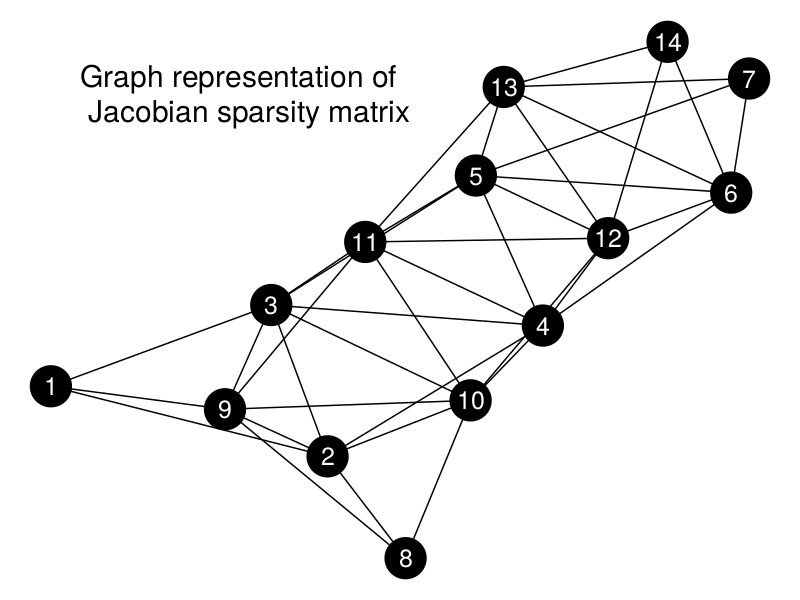

CairoMakie.Screen{SVG}


In [250]:
# Convert the sparsity pattern to a graph
g = sparsity_matrix_to_graph(sparsity)

# Plot the graph
plot_graph(g)

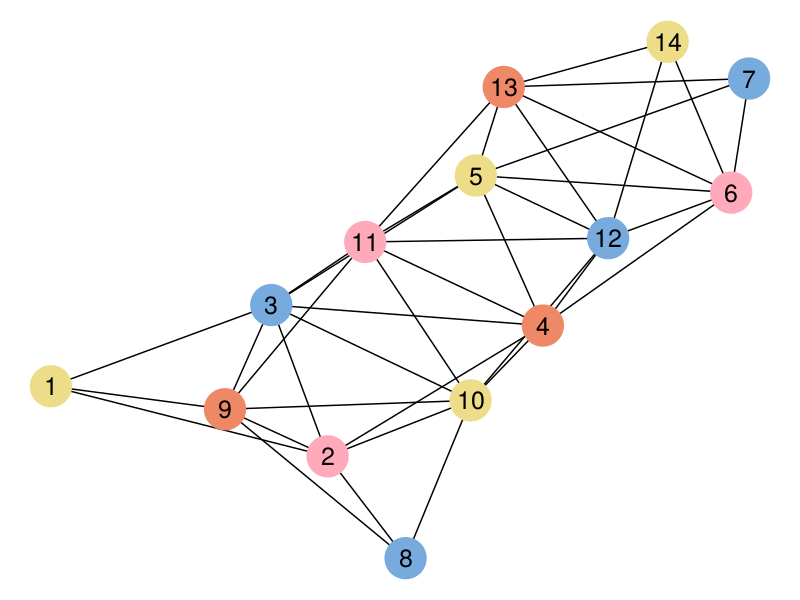

CairoMakie.Screen{SVG}


In [251]:
# Find the distance-1 coloring of the graph
coloring = greedy_color(g; sort_degree = true)

# Plot the graph with the distance-1 coloring
plot_graph(g, coloring)

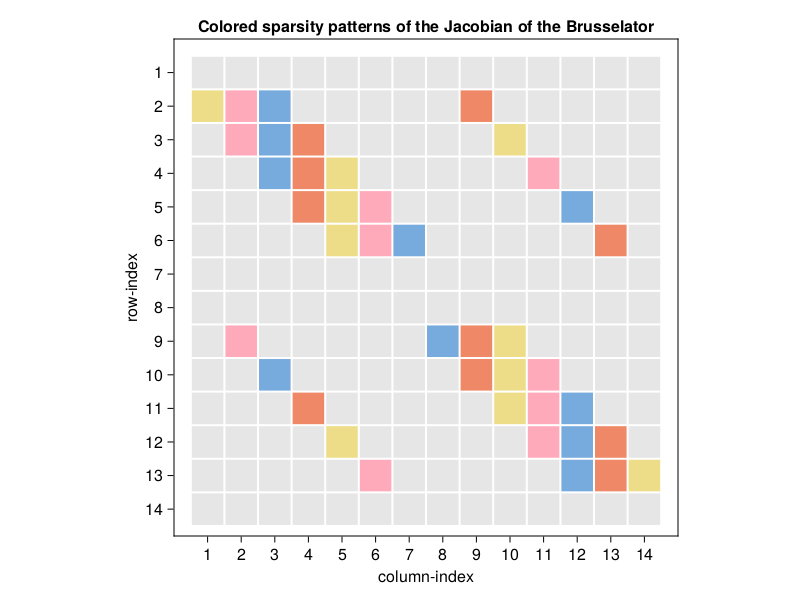

CairoMakie.Screen{IMAGE}


In [252]:
# Plot the sparsity pattern with the coloring found previously
plot_sparsity_pattern(sparsity, node_colors(coloring, g), "Colored sparsity patterns of the Jacobian of the Brusselator")

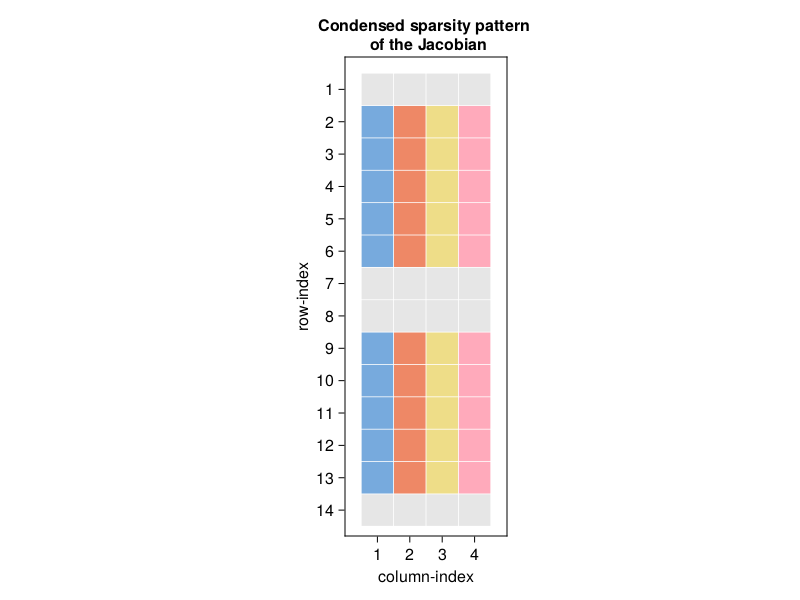

CairoMakie.Screen{IMAGE}


In [206]:
# Find the condensed pattern, i. e. the matrix resulting from
# overlapping the non-overlapping columns as found by the coloring
cm = condense_sparsity_pattern(sparsity, coloring)

# Plot the condensed pattern
plot_sparsity_pattern(cm, unique_colors(coloring), "Condensed sparsity pattern \n of the Jacobian")

## Forward Mode AD

In [253]:
dwdt0 = zeros(2(N + 2))
jac = ForwardDiff.jacobian(wbrusselator!, dwdt0, w)
# use https://github.com/JuliaDiff/SparseDiffTools.jl

55

14×14 Matrix{Float64}:
 0.0    0.0       0.0       0.0   …   0.0    0.0         0.0        0.0
 0.72   5.75615   0.72      0.0       0.0    0.0         0.0        0.0
 0.0    0.72      5.75615   0.72      0.0    0.0         0.0        0.0
 0.0    0.0       0.72      0.56      1.0    0.0         0.0        0.0
 0.0    0.0       0.0       0.72      0.0    0.0179492   0.0        0.0
 0.0    0.0       0.0       0.0   …   0.0    0.0         0.0179492  0.0
 0.0    0.0       0.0       0.0       0.0    0.0         0.0        0.0
 0.0    0.0       0.0       0.0       0.0    0.0         0.0        0.0
 0.0   -8.19615   0.0       0.0       0.0    0.0         0.0        0.0
 0.0    0.0      -8.19615   0.0       0.72   0.0         0.0        0.0
 0.0    0.0       0.0      -3.0   …  -2.44   0.72        0.0        0.0
 0.0    0.0       0.0       0.0       0.72  -1.45795     0.72       0.0
 0.0    0.0       0.0       0.0       0.0    0.72       -1.45795    0.72
 0.0    0.0       0.0       0.0       0.